<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2022/blob/main/notebooks/es10/MetodiAI_Fis2022_Es10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelli generativi basati su VAE e GAN

scopo: familiarizzare con la progettazione e l'uso di archietture generative basate su VAE e GAN 

DL tool: pytorch

### tasks ###

1.   implementazione di una beta-VAE (eg una VAE con un iperparametro che per controllare il peso relativo del termine di divergenza rispetto al termine di ricostruzione nella loss
2.   implementazione di una Deep Convolutional GAN (DCGAN) addestrata per generare immagini realistiche del dataset fashion-MNIST

Referenze:

*   [VAE](https://arxiv.org/abs/1312.6114) e [beta-VAE](https://openreview.net/forum?id=Sy2fzU9gl)
*   [DCGAN](https://arxiv.org/pdf/1511.06434.pdf)


**Datasets:**

*   [MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) e [fashion-MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) benchmarks da pytorch datasets

In [ ]:
# Install required packages.
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import os

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

1.11.0+cu113


In [ ]:
# MNIST dataset

dataset_train = datasets.MNIST(
    root = 'data', 
    train = True,  # True: train dataset, False: test dataset                     
    transform = ToTensor(), #transforms to torch tensors input data (note aslo normlized it in [0,1])
    download = True,  #download locally the dataset       
)

dataset_test = datasets.MNIST(
    root = 'data', 
    train = False,  # True: train dataset, False: test dataset                     
    transform = ToTensor(), #transforms to torch tensors input data (note aslo normlized it in [0,1])
    download = True,  #download locally the dataset       
)

print(dataset_train)
print(dataset_test)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
# per questa esercitazione è consigliabile usare una GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# dataloaders

batch_size = 128
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=True)

In [ ]:
# Convolutional Encoder Model

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=hidden_channels, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=hidden_channels, 
                               out_channels=hidden_channels*2, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1) # output: hidden_channels x 2 x 7 x 7

        self.fc_mu = nn.Linear(in_features=hidden_channels*2*7*7, 
                               out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=hidden_channels*2*7*7, 
                                   out_features=latent_dim)
            
        self.activation = nn.ReLU()

    def forward(self, x):
    
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))

        x = x.view(x.shape[0], -1) #flatten

        # prediction from the encoder: mu and logvariance
        # more stable wrt mu and sigma: https://stats.stackexchange.com/a/353222/284141 
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)

        return x_mu, x_logvar

In [ ]:
# Convolutional Decoder Model

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim, 
                            out_features=hidden_channels*2*7*7)

        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2, 
                                        out_channels=hidden_channels, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels, 
                                        out_channels=1, 
                                        kernel_size=4, 
                                        stride=2, 
                                        padding=1)
        
        self.activation = nn.ReLU()
        
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels*2, 7, 7)
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

In [ ]:
# Full AE/VAE Model
# modified implementation from original code from Antonio Norelli e Luca Moschella

use_VAE = True #False: AE, True: VAE

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        #VAE/AE
        if use_VAE:
          latent = self.latent_sample(latent_mu, latent_logvar)
        else:
          latent = latent_mu
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    # sampling function (implements the reparametrization trick)
    def latent_sample(self, mu, logvar):
        if self.training:
            sigma = (logvar * 0.5).exp()  # logvar -> sigma

            # reparameterization trick, using troch probability distributions package
            return torch.distributions.Normal(loc=mu, scale=sigma).rsample()
        else:
            return mu

In [ ]:
# Instanziate and print the model

hidden_channels = 64
latent_dim = 2 #dimensione dello spazio latente z

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_vae = VAE(encoder, decoder)

print(model_vae)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model_vae.cuda(), input_size=(1,28,28))
else:
  summary(model_vae, input_size=(1,28,28))

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=6272, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=6272, out_features=2, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=6272, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation): ReLU()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,088
              ReLU-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         131,200
              ReLU-4            [-1, 128

In [ ]:
# test
model_vae=model_vae.to(device)
x,_ = next(iter(train_dataloader))
x=x.to(device)
xtilde, mu, logvar = model_vae(x)
print(xtilde.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# Loss reco + KLD

# beta loss (loss = reco + beta*kl-divergence)
beta_par = 1.0

# VAE loss
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    if use_VAE:
      # closed form of KL divergence for normal priors
      kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    else:
      kldivergence = 0.0
    return recon_loss + beta_par * kldivergence

In [ ]:
# Training

hidden_channels = 64
latent_dim = 2 #dimensione dello spazio latente z

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_vae = VAE(encoder, decoder)

model_vae = model_vae.to(device)

LR = 1.e-3
opt = torch.optim.Adam(params=model_vae.parameters(), lr=LR, weight_decay=1e-5)

In [ ]:
import time

epochs = 60
hist_loss = []

for epoch in range(epochs):
    t0 = time.time()
    
    # training step
    model_vae.train()
    train_loss = 0
    counter = 0

    for xb, _ in train_dataloader:
        counter += 1
        xb=xb.to(device)  

        xhat, mu, logvar = model_vae(xb)
        loss = vae_loss(xhat, xb, mu, logvar)

        train_loss += loss.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    hist_loss.append(train_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f" 
          % (epoch+1, elapsed_time, train_loss))

epoch: 1, time(s): 6.8763, train loss: 23516.369545
epoch: 2, time(s): 6.7381, train loss: 21282.147757
epoch: 3, time(s): 6.9193, train loss: 20612.951714
epoch: 4, time(s): 6.7392, train loss: 20264.586334
epoch: 5, time(s): 7.7247, train loss: 20042.255793
epoch: 6, time(s): 6.6983, train loss: 19861.965299
epoch: 7, time(s): 6.7240, train loss: 19749.810705
epoch: 8, time(s): 6.7411, train loss: 19643.527031
epoch: 9, time(s): 6.7487, train loss: 19566.165974
epoch: 10, time(s): 6.7085, train loss: 19486.870464
epoch: 11, time(s): 6.6670, train loss: 19435.124078
epoch: 12, time(s): 6.7696, train loss: 19389.433030
epoch: 13, time(s): 6.6894, train loss: 19346.942470
epoch: 14, time(s): 6.7557, train loss: 19287.257712
epoch: 15, time(s): 6.7070, train loss: 19252.524301
epoch: 16, time(s): 6.6700, train loss: 19203.673594
epoch: 17, time(s): 6.6814, train loss: 19178.665640
epoch: 18, time(s): 6.7354, train loss: 19154.061590
epoch: 19, time(s): 6.7463, train loss: 19118.804984
ep

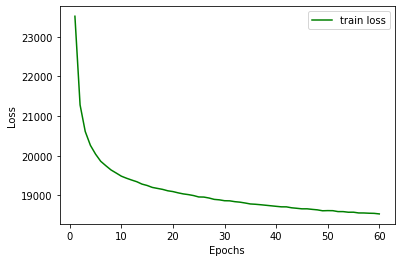

In [ ]:
# training loss plot
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

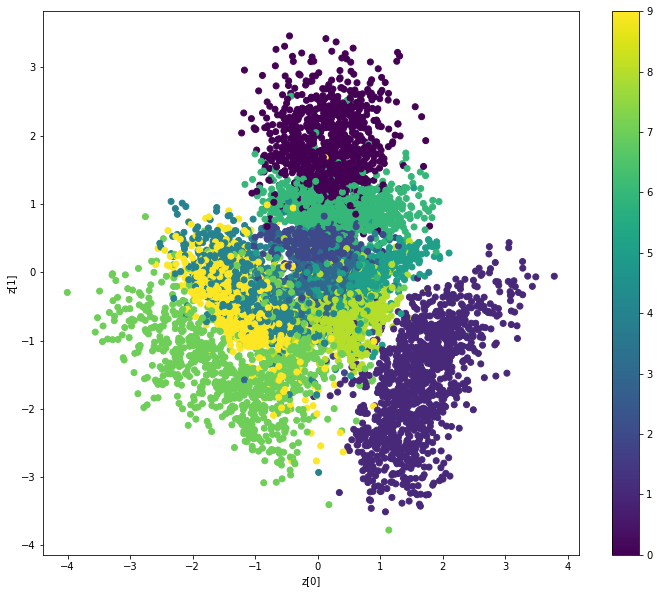

In [ ]:
# Plot dello spazio latente appreso (z1 vs z2)

model_vae.eval()

z = np.empty(shape=(len(test_dataloader),2))
y = np.empty(shape=(len(test_dataloader)))
counter = 0
with torch.no_grad(): 
  for idx, (xb, yb) in enumerate(test_dataloader):
    xb=xb.to(device)  
    z_mean, _ = encoder(xb)
    z[idx,0] = z_mean[0,0].item()
    z[idx,1] = z_mean[0,1].item()
    y[idx] = yb.item()

plt.figure(figsize=(12, 10))
plt.scatter(z[:, 0], z[:, 1], c=y)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

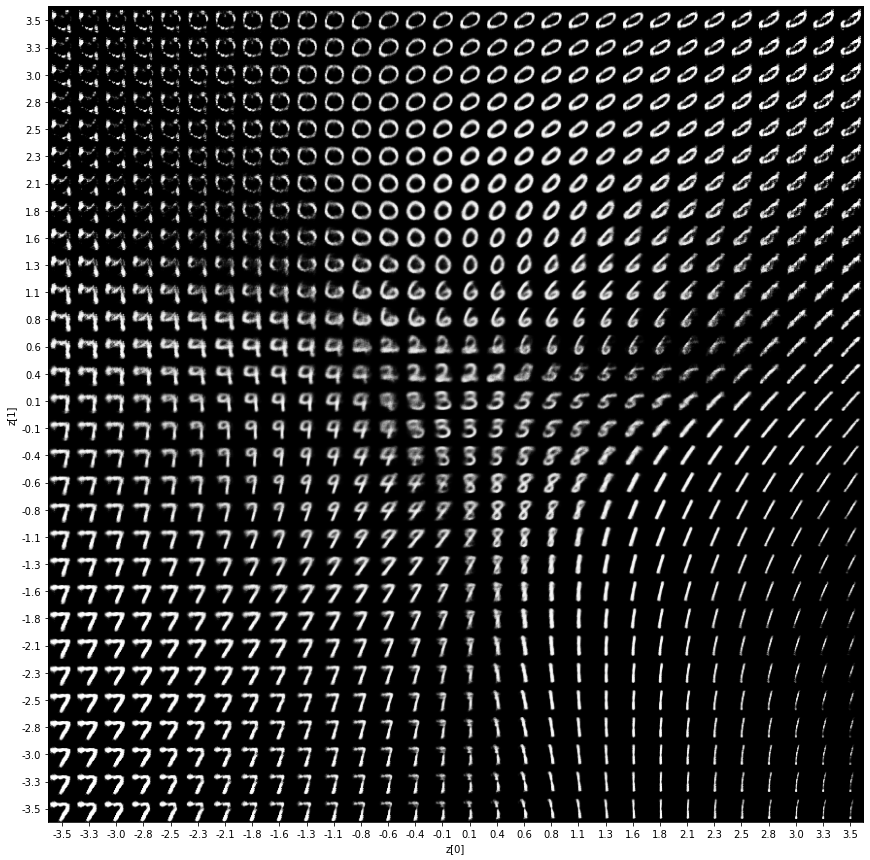

In [ ]:
# uso come generatore

# plotta una matrice nxn di immagini generatre dal decoder della VAE ottenute facendo uno scan delle due dimensioni latenti [z1,z2]

model_vae.eval()
def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 3.5
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([xi, yi]).float() #vettore z 
            z_sample = z_sample.view(1,2)
            z_sample=z_sample.to(device)
            x_decoded = decoder(z_sample) #decoder(z)
            x_decoded=x_decoded.cpu()
            digit = x_decoded[0].view(28,28).detach().numpy() #(1,28,28) -> (28,28)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(decoder)

### DCGAN GAN on fashion MNIST

In [ ]:
# Fashion MNIST dataset

dataset_train = datasets.FashionMNIST(
    root = 'data', 
    train = True,  # True: train dataset, False: test dataset                     
    transform = ToTensor(), #transforms to torch tensors input data (note aslo normlized it in [0,1])
    download = True,  #download locally the dataset       
)

dataset_test = datasets.FashionMNIST(
    root = 'data', 
    train = False,  # True: train dataset, False: test dataset                     
    transform = ToTensor(), #transforms to torch tensors input data (note aslo normlized it in [0,1])
    download = True,  #download locally the dataset       
)

print(dataset_train)
print(dataset_test)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
# dataloaders

batch_size = 64
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=True)

In [ ]:
# DCGAN model from pytorch web site (https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images.
image_size = 28

# Number of channels in the training images 1: scala di grigio, 3: immagini a colori RGB
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

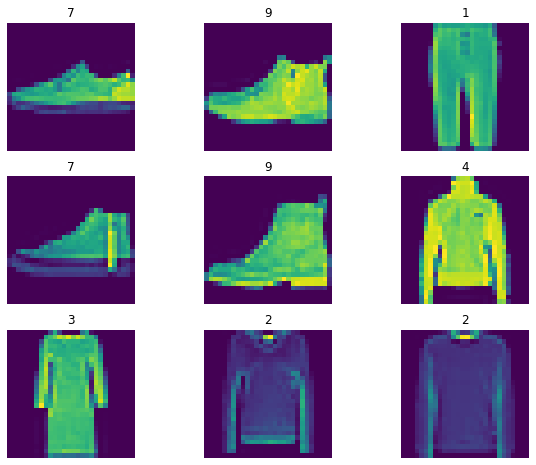

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
    img, label = dataset_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze()) #nota: imshow si aspetta shape (h,w,channels)
plt.show()

In [ ]:
# custom weights initialization per il generatore e discriminatore
# dall'articolo oroginale DGGAN "all model weights shall be randomly initialized from 
# a Normal distribution with mean=0, stdev=0.02"
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.main = nn.Sequential(
          # input is Z, going into a convolution
          nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf * 4),
          nn.ReLU(True),
          # state size. (ngf*4) x 4 x 4
          nn.ConvTranspose2d(ngf * 4, ngf * 2, 2, 2, 0, bias=False),
          nn.BatchNorm2d(ngf * 2),
          nn.ReLU(True),
          # state size. (ngf*4) x 8 x 8
          nn.ConvTranspose2d( ngf * 2, ngf, 2, 2, 0, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),
          # state size. (ngf) x 16 x 16
          nn.ConvTranspose2d( ngf, nc, 2, 2, 2, bias=False),
          nn.Tanh()
          # state size. (nc) x 28 x 28
      )

    def forward(self, input):
      return self.main(input)


In [ ]:
# crea un batch di 64 vettori latenti z da usare per monitorare le immagini generate dal generatore a epoche diverse

fixed_noise = torch.randn(64, nz, 1, 1)

print(fixed_noise.shape)

torch.Size([64, 100, 1, 1])


In [ ]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

from torchsummary import summary
if torch.cuda.is_available():
  summary(netG.cuda(), input_size=(100,1,1))
else:
  summary(netG.cuda(), input_size=(100,1,1))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), bias=False)
    (10): Tanh()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 4, 4]         204,800
       BatchNorm2d-2            [-1, 128, 4, 4]             2

In [ ]:
# test generator

z = torch.randn(1, nz, 1, 1)
z = z.cpu()

netG=netG.cpu()
out = netG(z)

print(out.shape)

torch.Size([1, 1, 28, 28])


In [ ]:
# discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 2, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(ndf, ndf * 2, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

from torchsummary import summary
if torch.cuda.is_available():
  summary(netD.cuda(), input_size=(1,28,28))
else:
  summary(netD.cuda(), input_size=(1,28,28))

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             128
         LeakyReLU-2           [-1, 32, 15, 15]               0
           

In [ ]:
# test discriminator

img = torch.randn(1, 1, 28, 28)
img = img.cpu()

netD=netD.cpu()
out = netD(img)

print(out.shape)

torch.Size([1, 1, 1, 1])


In [ ]:
# Loss e ottimizzatori

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop
import torchvision.utils as vutils

netG=netG.to(device)
netD=netD.to(device)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/937]	Loss_D: 1.2565	Loss_G: 1.0222	D(x): 0.5808	D(G(z)): 0.4882 / 0.3771
[0/5][50/937]	Loss_D: 0.1075	Loss_G: 3.9547	D(x): 0.9410	D(G(z)): 0.0409 / 0.0272
[0/5][100/937]	Loss_D: 0.0571	Loss_G: 5.5748	D(x): 0.9895	D(G(z)): 0.0446 / 0.0055
[0/5][150/937]	Loss_D: 0.0757	Loss_G: 3.7862	D(x): 0.9883	D(G(z)): 0.0609 / 0.0281
[0/5][200/937]	Loss_D: 0.2273	Loss_G: 2.3967	D(x): 0.8393	D(G(z)): 0.0404 / 0.1089
[0/5][250/937]	Loss_D: 0.1164	Loss_G: 3.2056	D(x): 0.9412	D(G(z)): 0.0521 / 0.0494
[0/5][300/937]	Loss_D: 0.2397	Loss_G: 3.5083	D(x): 0.8479	D(G(z)): 0.0362 / 0.0399
[0/5][350/937]	Loss_D: 0.1486	Loss_G: 2.8730	D(x): 0.9183	D(G(z)): 0.0547 / 0.0694
[0/5][400/937]	Loss_D: 0.1081	Loss_G: 3.7944	D(x): 0.9411	D(G(z)): 0.0415 / 0.0288
[0/5][450/937]	Loss_D: 0.1543	Loss_G: 2.6477	D(x): 0.8957	D(G(z)): 0.0358 / 0.0911
[0/5][500/937]	Loss_D: 0.1143	Loss_G: 3.9008	D(x): 0.9569	D(G(z)): 0.0646 / 0.0299
[0/5][550/937]	Loss_D: 0.1270	Loss_G: 4.2540	D(x): 0.9467	D(G(z)

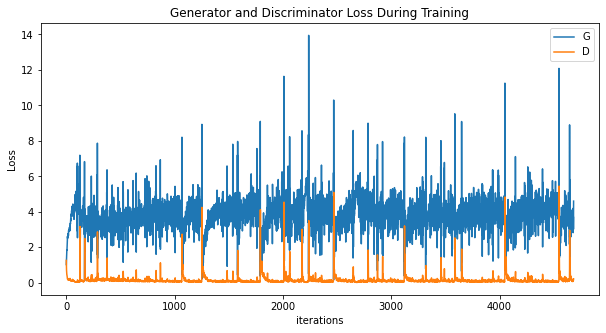

In [ ]:
# plot dei valori delle loss per D e G durante il training D
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

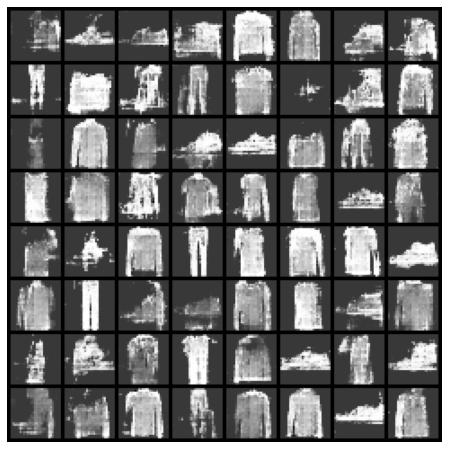

In [ ]:
# plot dell'output di G per il set fixed_batch generato all'inizio

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


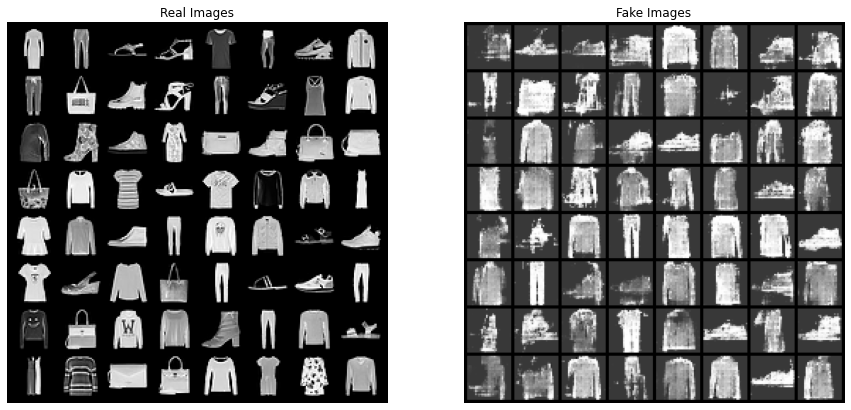

In [ ]:
# plot di un batch di immagini reali vs un batch di immagini generate da G

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()